In [164]:
%reset -f

In [165]:
import os
import sys
import scipy as sp
import numpy as np
import astropy as ap
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import astropy.cosmology as apc
from astropy.cosmology import Planck18
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import fitsio
import kcorrect
sys.path.append('/home/ygence/kmeans_radec')
import kmeans_radec as kr

c = 3e18    #A * Hz
cosmo = FlatLambdaCDM(H0=70, Om0=0.3065)

In [166]:
path = '/shares/soares-santos.physik.uzh/catalogs'
f = os.path.join(path, 'des_y6_gold.fits')

In [167]:
# gets column names
fitsio.read_header(f, ext=1)


XTENSION= 'BINTABLE'           / binary table extension
BITPIX  =                    8 / 8-bit bytes
NAXIS   =                    2 / 2-dimensional binary table
NAXIS1  =                  290 / width of table in bytes
NAXIS2  =            691483608 / number of rows in table
PCOUNT  =                    0 / size of special data area
GCOUNT  =                    1 / one data group (required keyword)
TFIELDS =                   39 / number of fields in each row
TTYPE1  = 'COADD_OBJECT_ID'    / label for field   1
TFORM1  = 'K'                  / data format of field: 8-byte INTEGER
TTYPE2  = 'ALPHAWIN_J2000'     / label for field   2
TFORM2  = 'D'                  / data format of field: 8-byte DOUBLE
TTYPE3  = 'DELTAWIN_J2000'     / label for field   3
TFORM3  = 'D'                  / data format of field: 8-byte DOUBLE
TTYPE4  = 'RA'                 / label for field   4
TFORM4  = 'D'                  / data format of field: 8-byte DOUBLE
TTYPE5  = 'DEC'                / label for fiel

In [168]:
# loading data (1e6 to start)
rows = range(545000000,546000000)
fits = fitsio.read(f, rows=rows, ext=1)

In [169]:
magmaskfg = fits["BDF_FLUX_G_CORRECTED"] > 0
magmaskfr = fits["BDF_FLUX_R_CORRECTED"] > 0
magmaskfi = fits["BDF_FLUX_I_CORRECTED"] > 0
magmaskfz = fits["BDF_FLUX_Z_CORRECTED"] > 0
magmaskfy = fits["BDF_FLUX_Y_CORRECTED"] > 0

zmaskl = fits['DNF_Z'] > 0
zmasku = fits['DNF_Z'] < 2

galmask1 = fits['EXT_MASH'] == 4
galmask2 = fits['EXT_MASH'] == 3

masky_total = magmaskfg & magmaskfr &  magmaskfi &  magmaskfz & magmaskfy & zmaskl & zmasku
galmask = galmask1 | galmask2
mask_total = masky_total & galmask

In [170]:
fits = fits[mask_total]
fits.shape

(657939,)

Data Loading & Preparing

In [177]:
x = len(fits)

flux_list = []
fluxerr_list = []

for i in range(x):
    flux = np.array([fits[i]['BDF_FLUX_G_CORRECTED'],fits[i]['BDF_FLUX_R_CORRECTED'],fits[i]['BDF_FLUX_I_CORRECTED'],fits[i]['BDF_FLUX_Z_CORRECTED'],fits[i]['BDF_FLUX_Y_CORRECTED']]) # fluxes
    flux_list.append(flux)
    fluxerr = np.array([fits[i]['BDF_FLUX_ERR_G_CORRECTED'],fits[i]['BDF_FLUX_ERR_R_CORRECTED'],fits[i]['BDF_FLUX_ERR_I_CORRECTED'],fits[i]['BDF_FLUX_ERR_Z_CORRECTED'],fits[i]['BDF_FLUX_ERR_Y_CORRECTED']]) # fluxes
    fluxerr_list.append(fluxerr)

scaler = np.array(1e-12)
scaler = np.broadcast_to(scaler.reshape(-1,1), (x,1))

flux_list = flux_list*scaler
fluxerr_list = fluxerr_list*scaler
ivar_list = fluxerr_list**-2

ra = fits['ALPHAWIN_J2000']
ra[ra > 180.] -= 360.
dec = fits['DELTAWIN_J2000']

phot_reds = fits['DNF_Z']         # photometric redshifts
phot_reds_err = fits['DNF_ZSIGMA']    # redshift errors

d_L = cosmo.luminosity_distance(phot_reds)/u.Mpc
d_Lerr = cosmo.luminosity_distance(phot_reds_err)/u.Mpc

DM = 25 + 5*np.log10(d_L)
DM_err = 5/(np.log(10)*d_L) * d_Lerr

DM = np.broadcast_to(DM.reshape(-1,1), (x,5))
DM_err = np.broadcast_to(DM_err.reshape(-1,1), (x,5))

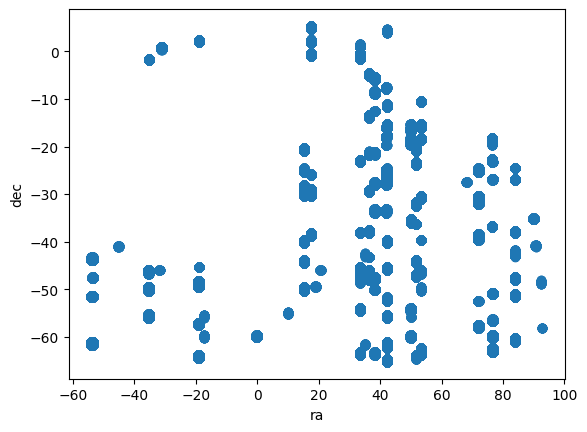

In [172]:
# visualizing the galaxies on the sky
plt.scatter(ra, dec)
plt.xlabel('ra')
plt.ylabel('dec')
plt.show()
plt.close()

# K correction

In [185]:
# getting k correction values
responses = ['decam_g','decam_r','decam_i','decam_z','decam_Y']
kz = kcorrect.kcorrect.Kcorrect(responses=responses, cosmo=cosmo)

maggies = flux_list
ivar = ivar_list    # inverse variance = (1/std.dev.)^2
redshift = phot_reds

coeffs = kz.fit_coeffs(redshift=redshift, maggies=maggies, ivar=ivar)

K = kz.kcorrect(redshift=redshift, coeffs=coeffs)       # we have k values to clean out redshift effects from the appmag

derived = kz.derived(redshift=redshift, coeffs=coeffs)
sm = derived['mremain']

In [181]:
mag_list = -2.5*np.log10(flux_list)
mag_err_list = fluxerr_list * 2.5/(np.log(10)*flux_list)

In [186]:
M = []
for i in range(x):
    M_calc = mag_list[i] -DM[i] -K[i]
    M.append(M_calc)
M = np.array(M)

In [187]:
err_M = []
for i in range(x):
    M_calc_err = np.sqrt(mag_err_list[i]**2 + DM_err[i]**2)
    err_M.append(M_calc_err)
err_M = np.array(err_M)

Visualisation

In [188]:
M_g = np.array([row[0] for row in M])
M_r = np.array([row[1] for row in M])
M_i = np.array([row[2] for row in M])
M_z = np.array([row[3] for row in M])
M_y = np.array([row[4] for row in M])

In [189]:
err_M_g = np.array([row[0] for row in err_M])
err_M_r = np.array([row[1] for row in err_M])
err_M_i = np.array([row[2] for row in err_M])
err_M_z = np.array([row[3] for row in err_M])
err_M_y = np.array([row[4] for row in err_M])

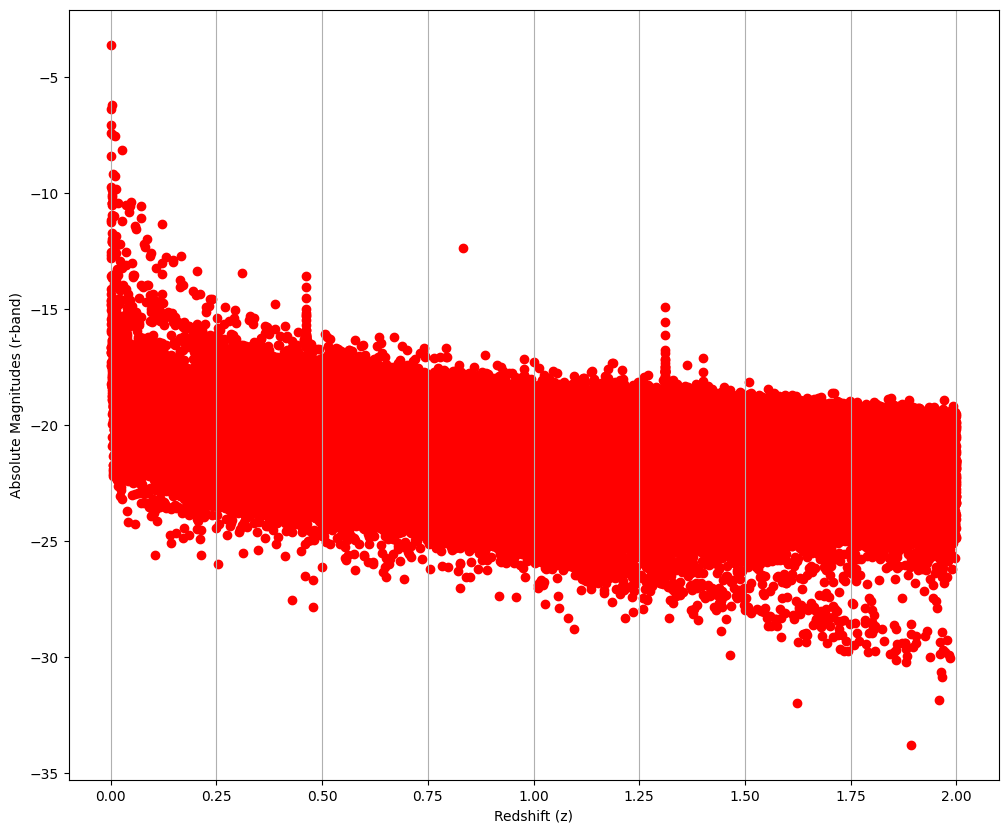

In [190]:
fig, ax = plt.subplots()
plt.scatter(phot_reds, M_r, marker="o", c='r')

ax.set_yscale('linear')
ax.set_xscale('linear')

ax.set_xlabel('Redshift (z)')
ax.set_ylabel('Absolute Magnitudes (r-band)')

ax.grid(axis='x')

fig.set_size_inches(12,10)
plt.show()
plt.close()

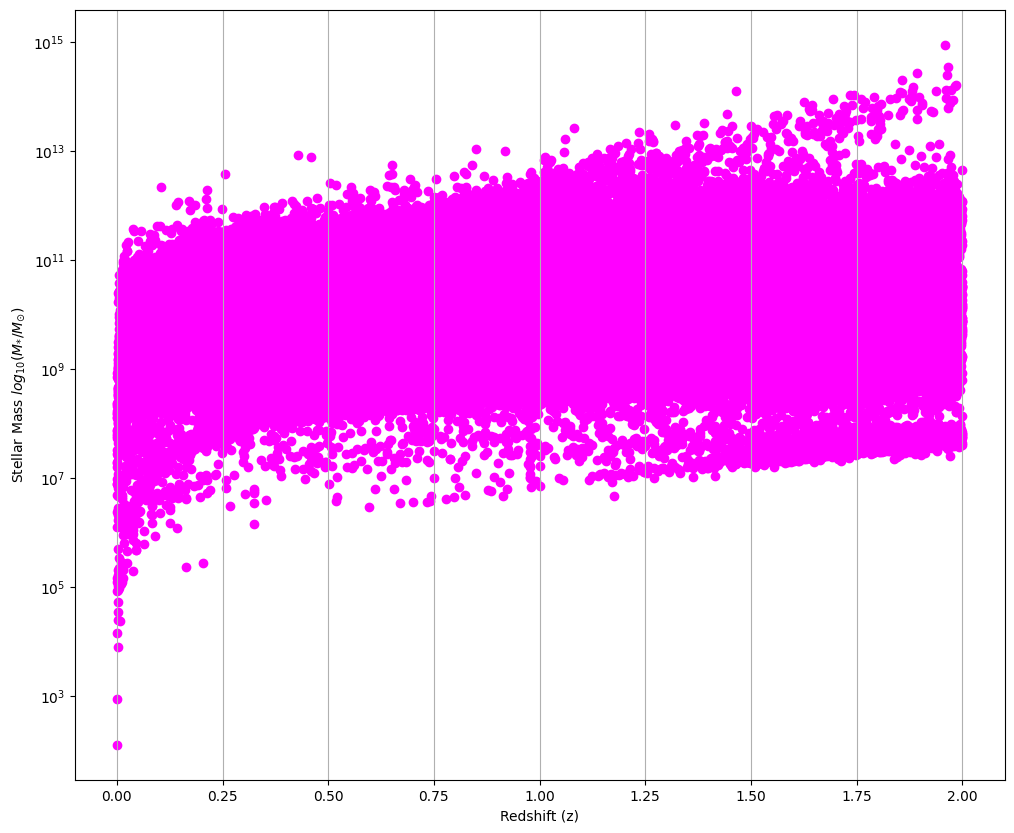

In [191]:
fig, ax = plt.subplots()
plt.scatter(phot_reds, sm, marker='o', c='fuchsia')

ax.set_yscale('log')
ax.set_xscale('linear')

ax.set_ylabel(r'Stellar Mass $log_{10}(M_{*}/M_{\odot})$')
ax.set_xlabel('Redshift (z)')
ax.grid(axis='x')

fig.set_size_inches(12,10)
plt.show()
plt.close()

Data Saving

In [192]:
neofits = fitsio.FITS('/home/ygence/scratch/DES_Y6_1M.fits','rw')
arr_list = [phot_reds, phot_reds_err, M_g, err_M_g, M_r, err_M_r, M_i, err_M_i, M_z, err_M_z, M_y, err_M_y, sm, ra, dec]
names = ['z','z_err','M_g','M_err_g','M_r','M_err_r','M_i','M_err_i','M_z','M_err_z','M_y','M_err_y','SM','ra','dec']
neofits.write(arr_list, names=names)
#neofits[-1].append(arr_list,names=names)
neofits.close()

# Schechter Form of the Luminosity Function

In [8]:
%reset -f

In [3]:
import os
import sys
import scipy as sp
import numpy as np
import astropy as ap
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import astropy.cosmology as apc
from astropy.cosmology import Planck18
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import fitsio
import kcorrect
sys.path.append('/home/ygence/kmeans_radec')
import kmeans_radec as kr

sch_c = 3e5 * u.km/u.s
cosmo = FlatLambdaCDM(H0=70, Om0=0.3065)

In [4]:
fitsio.read_header('/home/ygence/scratch/DES_Y6_1M.fits',ext=2)


XTENSION= 'BINTABLE'           / binary table extension
BITPIX  =                    8 / 8-bit bytes
NAXIS   =                    2 / 2-dimensional binary table
NAXIS1  =                   72 / width of table in bytes
NAXIS2  =                  100 / number of rows in table
PCOUNT  =              4939712 / size of special data area
GCOUNT  =                    1 / one data group (required keyword)
TFIELDS =                    8 / number of fields in each row
TTYPE1  = 'center_pos'         / label for field   1
TFORM1  = '2D'                 / data format of field: 8-byte DOUBLE
TTYPE2  = 'cell_list'          / label for field   2
TFORM2  = '1PK(9304)'          / data format of field: variable length array
TTYPE3  = 'M_star'             / label for field   3
TFORM3  = 'D'                  / data format of field: 8-byte DOUBLE
TTYPE4  = 'err_M_star'         / label for field   4
TFORM4  = 'D'                  / data format of field: 8-byte DOUBLE
TTYPE5  = 'alpha'              / label f

In [12]:
maskMl = fits['M_r'] > (-27.5)
maskMh = fits['M_r'] < (-15)
maskz = fits['z'] < 2.
maskM = maskMl & maskMh & maskz
fits = fits[maskM]

In [13]:
ra = fits['ra']
dec = fits['dec']

schM = fits['M_r']
schM_err = fits['M_err_r']
schM_l = schM.min()
schM_u = schM.max()

sch_z = fits['z']
sch_z_err = fits['z_err']
sch_z_max = sch_z.max()

sch_dl = cosmo.luminosity_distance(sch_z)

In [14]:
X = np.array([ra,dec]).T

cellno = 100

In [15]:
# run no more than 100 iterations. Will stop if tolerance is met
km = kr.kmeans_sample(X, cellno, maxiter=100, tol=1.0e-5)

# we got back a KMeans object:

# the centers found by the algorithm
print("found centers:",km.centers)

# did we converge?
print("converged?",km.converged)

# labels are the index to the nearest center for each point in X
print("labels size:",km.labels.size)

# how many in each cluster? Should be fairly uniform
print("cluster sizes:", np.bincount(km.labels))

# the distance to each center [Npoints, Ncen]
print("shape of distances:",km.distances.shape)

centers = km.centers

X (1571, 2)  centers (100, 2)  tol=1e-05  maxiter=100
16 iterations  cluster sizes: [15 13 15  8 14  8 13 17  8 16 11  8 21 18  9 10 10 16 12 25 11 16 14 30
 11 25 28  9 21 13 18 20 24 18 16 15 18 13 15 13 23 19 30 14 22 19 14 16
 23 13 19 16 14 14 13 10 15 18  7  8 12 22 24 12 10 20 16  8  8 16 14 16
 19 18 25 13 18 16 15 18 17 16 13 17  8 20 13 18 14 12 18 24 14 11 29 13
  7 12 21 12]
X (617464, 2)  centers (100, 2)  tol=1e-05  maxiter=100
100 iterations  cluster sizes: [7162 6195 6164 5164 6221 5690 6573 5824 5163 6511 6236 6145 6686 7508
 6057 6218 5641 6085 5449 6739 5356 6184 6667 5343 5693 6064 7286 5850
 5238 5792 6580 6666 7080 5684 5998 5509 5481 5953 5944 6297 6252 7126
 6163 6104 5872 6944 7652 5943 6336 4830 5854 6275 6389 6595 5850 5880
 6712 6414 6390 5832 5759 6443 6682 4917 5323 6429 5266 6690 5680 6856
 6144 6933 6102 5558 6785 5211 7292 5690 5209 6078 5658 7277 5651 6442
 6108 7283 6190 9304 6192 6525 6053 6430 5836 5436 6682 5858 5892 5854
 5965 6272]
found centers:

In [16]:
cell_list = [[] for _ in range(cellno)]
num = np.arange(0,cellno)
eventno = len(sch_z)

for i in np.arange(0,eventno):
    cell_list[km.labels[i]].append(i)


Defining the the comoving volume function (Eales 1993)

In [17]:
def V(x):
    return ((1+x)**2 * np.sqrt(cosmo.Ode0 + cosmo.Om0 * (1+x)**3))**(-1)

survey_area = 4946
integ,_ = sp.integrate.quad(lambda x:V(x), 0,sch_z_max)
V_max = np.array(survey_area*sch_c*sch_dl**2/cosmo.H0 * integ /u.Mpc**3)   # defining Vmax

<Axes: >

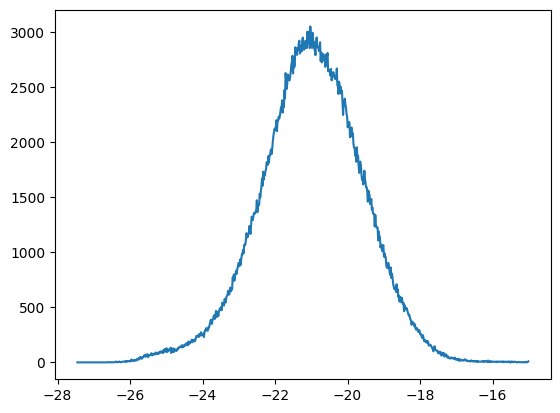

In [18]:
counts,edges = np.histogram(schM, bins=int(np.sqrt(len(schM)))) # binning the absolute mags
optedges = 0.5*(edges[1:]+edges[:-1])
s=pd.Series(counts,index=optedges)
s.plot()

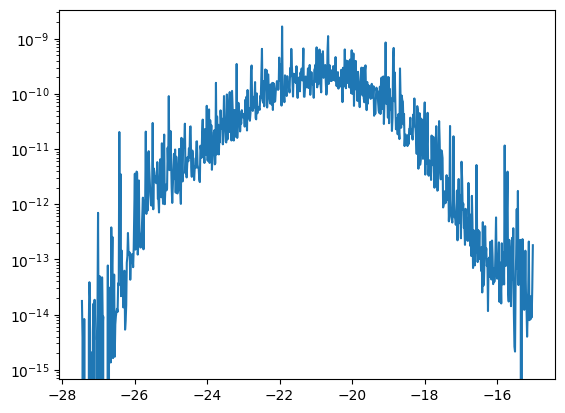

In [19]:
sumIV_max_binned = np.zeros(len(counts))    # 1/Vmax summation based on the absmag bins

prevEnd = 0

for idx, count in enumerate(counts):
    V_max_for_count = V_max[prevEnd:prevEnd+count]
    sumIV_max_binned[idx] = np.sum(1/V_max_for_count)

    prevEnd = prevEnd + count

plt.plot(optedges, sumIV_max_binned)
plt.yscale('log')

Defining the Schechter function

In [20]:
from scipy.optimize import curve_fit

#single
def func(x, M_star, alpha, phi):
    return 0.4*np.log(10)*phi*10**(-0.4*(1+alpha)*(x-M_star))*np.exp(-1*(10)**(-0.4*(x-M_star)))

#double
def doubfunc(x, M_star, alpha1, phi1, alpha2, phi2):
    return 0.4*np.log(10)*(phi1*10**(-0.4*(1+alpha1)*(x-M_star))+phi2*10**(-0.4*(1+alpha2)*(x-M_star)))*np.exp(-1*(10)**(-0.4*(x-M_star)))

In [21]:
#fit_sel = (optedges > -24) & (optedges < -16)       # masking for bad data

coeffs, cov = curve_fit(func, optedges, sumIV_max_binned, p0=[-21,-1,1]) #fitting the Schechter function

stddev = np.sqrt(cov) #recovering the std. dev.

stddiag = [-stddev[0,0],-stddev[1,1],stddev[2,2]] # to keep the error bar lines consistent

coeffs, cov

(array([-2.14143361e+01, -1.62379957e-01,  7.77534938e-10]),
 array([[1.12443076e-02, 6.42904790e-03, 2.51893461e-12],
        [6.42904790e-03, 4.96438758e-03, 1.94492931e-12],
        [2.51893461e-12, 1.94492931e-12, 1.38880913e-21]]))

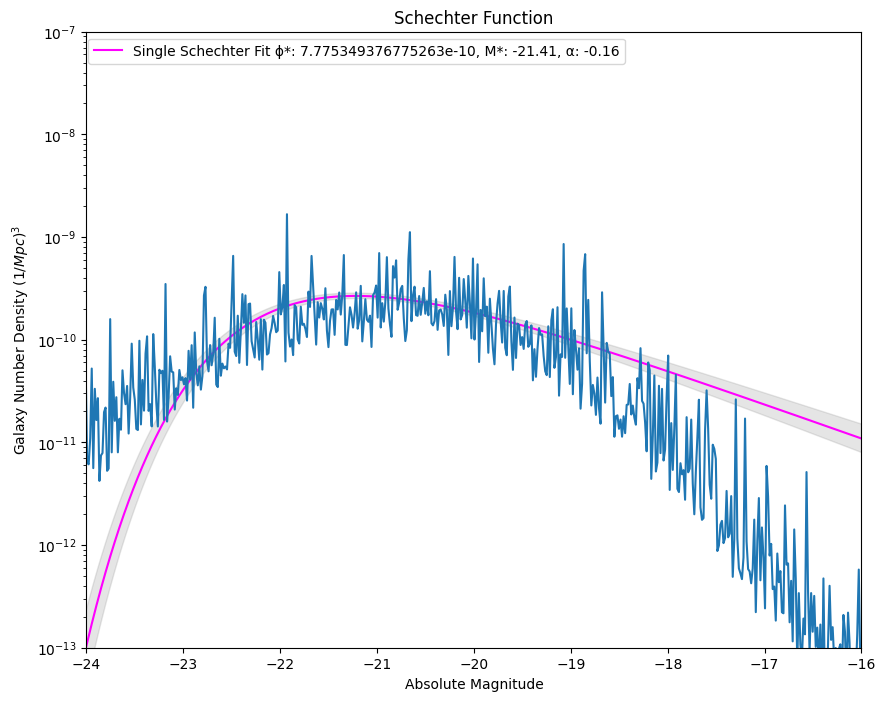

In [22]:
fig, ax = plt.subplots()
ax.plot(optedges, func(optedges,*coeffs), color='fuchsia', label=[f'Single Schechter Fit ϕ*: {coeffs[2]}, M*: {coeffs[0]:.2f}, α: {coeffs[1]:.2f}'])
ax.fill_between(optedges,func(optedges,*(coeffs+stddiag)), func(optedges,*(coeffs-stddiag)), alpha=0.2 ,where=(func(optedges,*(coeffs+stddiag))>func(optedges,*(coeffs-stddiag))), color='grey')
ax.plot(optedges, sumIV_max_binned)
ax.set_xlabel('Absolute Magnitude')
ax.set_ylabel(r'Galaxy Number Density $(1/Mpc)^{3}$')
ax.set_title('Schechter Function')
ax.set_yscale('log')
ax.set_xscale('linear')
ax.set_xbound(-24,-16)           #enable to see a close-up
ax.set_ybound(1e-13,1e-7)
fig.set_size_inches(10,8)
fig.legend(loc='upper left', bbox_to_anchor=(0.12,0.88))
plt.show()

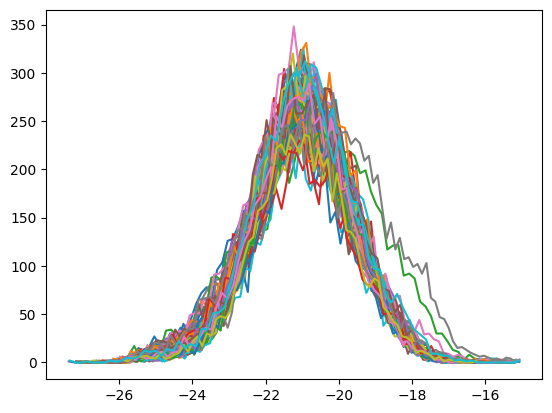

In [23]:
counts_list = []
optedges_list = []
for i in num:
    a,b = np.histogram(schM[cell_list[i]], bins=int(np.sqrt(len(schM[cell_list[i]])))) # binning the absolute mags
    counts_list.append(a)
    edges = 0.5*(b[1:]+b[:-1])
    optedges_list.append(edges)
    s=pd.Series(a,index=edges)
    s.plot()

In [24]:
sumIV_max_binned_total = []

prevEnd = 0

for i in range(cellno):
    sumIV_max_binned = np.zeros(len(counts_list[i]))
    
    for idx, count in enumerate(counts_list[i]):
        V_max_for_count = V_max[prevEnd:prevEnd+count]
        sumIV_max_binned[idx] = np.sum(1/V_max_for_count)

    sumIV_max_binned_total.append(sumIV_max_binned)

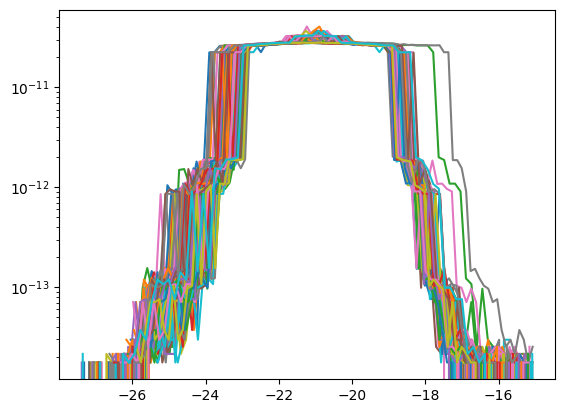

In [25]:
for i in range(cellno):
    plt.plot(optedges_list[i], sumIV_max_binned_total[i])
    plt.yscale('log')

In [26]:
#fit_sel = (optedges_list > -25) & (optedges_list < -17.5)       # basic masking
#roptedges = optedges_list[fit_sel]
coeffs_list = []
cov_list = []

for i in range(cellno):
    priors = [-20,-2,1]
    coeffs1, cov1 = curve_fit(func, optedges_list[i], sumIV_max_binned_total[i], p0=priors) #fitting the Schechter function
    if cov1[2,2] >= coeffs1[2]:
        priors[0] = priors[0]-1
        coeffs1, cov1 = curve_fit(func, optedges_list[i], sumIV_max_binned_total[i], p0=priors) #fitting the Schechter function
        if cov1[2,2] >= coeffs1[2]:
            priors[0] = priors[0]-1
            coeffs1, cov1 = curve_fit(func, optedges_list[i], sumIV_max_binned_total[i], p0=priors) #fitting the Schechter function
            if cov1[2,2] >= coeffs1[2]:
                priors[0] = priors[0]-1
                coeffs1, cov1 = curve_fit(func, optedges_list[i], sumIV_max_binned_total[i], p0=priors) #fitting the Schechter function
                if cov1[2,2] >= coeffs1[2]:
                    priors[0] = priors[0]-1
                    coeffs1, cov1 = curve_fit(func, optedges_list[i], sumIV_max_binned_total[i], p0=priors) #fitting the Schechter function
                    print('quad fix',i)
                    coeffs_list.append(coeffs1)
                    cov_list.append(cov1)
                else:
                    print('triple fix',i)
                    coeffs_list.append(coeffs1)
                    cov_list.append(cov1)
            else:
                print('double fix',i)
                coeffs_list.append(coeffs1)
                cov_list.append(cov1)
        else:
            print('single fix',i)
            coeffs_list.append(coeffs1)
            cov_list.append(cov1)
    else:
        print('direct hit',i)
        coeffs_list.append(coeffs1)
        cov_list.append(cov1)

direct hit 0
direct hit 1
direct hit 2
direct hit 3
direct hit 4
direct hit 5
direct hit 6
direct hit 7
direct hit 8
direct hit 9
direct hit 10
direct hit 11
direct hit 12
direct hit 13
direct hit 14
direct hit 15
direct hit 16
direct hit 17
direct hit 18
direct hit 19
direct hit 20
direct hit 21
direct hit 22
direct hit 23
direct hit 24
direct hit 25
direct hit 26
direct hit 27
direct hit 28
direct hit 29
direct hit 30
direct hit 31
direct hit 32
direct hit 33
direct hit 34
direct hit 35
direct hit 36
direct hit 37
direct hit 38
direct hit 39
direct hit 40
direct hit 41
direct hit 42
direct hit 43
direct hit 44
direct hit 45
direct hit 46
direct hit 47
direct hit 48
direct hit 49
direct hit 50
direct hit 51
direct hit 52
direct hit 53
direct hit 54
direct hit 55
direct hit 56
direct hit 57
direct hit 58
direct hit 59
direct hit 60
direct hit 61
direct hit 62
direct hit 63
direct hit 64
direct hit 65
direct hit 66
direct hit 67
direct hit 68
direct hit 69
direct hit 70
direct hit 71
di

In [27]:
stddiag_list = []
for i in range(cellno): 
    stddev = np.sqrt([cov_list[i][0,0],cov_list[i][1,1],cov_list[i][2,2]])
    stddiag = [-stddev[0],-stddev[1],stddev[2]]
    stddiag_list.append(stddiag)

In [28]:
cell_list1 = np.array(cell_list,dtype=object)
M_star = np.array([row[0] for row in coeffs_list])
alpha = np.array([row[1] for row in coeffs_list])
phi = np.array([row[2] for row in coeffs_list])
err_M = np.array([row[0] for row in stddiag_list])
err_alpha = np.array([row[1] for row in stddiag_list])
err_phi = np.array([row[2] for row in stddiag_list])

In [29]:
neofits = fitsio.FITS('/home/ygence/scratch/DES_Y6_1M.fits','rw')
arr_list = [centers, cell_list1, M_star, err_M, alpha, err_alpha, phi, err_phi]
names = ['center_pos','cell_list','M_star', 'err_M_star', 'alpha', 'err_alpha', 'phi','err_phi']
neofits.write(arr_list, names=names)
#neofits[-1].append(arr_list,names=names)
neofits.close()

In [ ]:
for i in range(cellno):
    fig, ax = plt.subplots()
    ax.plot(optedges_list[i], func(optedges_list[i],*coeffs_list[i]), color='fuchsia', label=[f'Single Schechter Fit  M*: {coeffs_list[i][0]:.2f}, α: {coeffs_list[i][1]:.2f}, ϕ*: {coeffs_list[i][2]}'])
    ax.fill_between(optedges_list[i],func(optedges_list[i],*(coeffs_list[i]+stddiag_list[i])), func(optedges_list[i],*(coeffs_list[i]-stddiag_list[i])),
                     alpha=0.2 ,where=(func(optedges_list[i],*(coeffs_list[i]+stddiag_list[i]))>func(optedges_list[i],*(coeffs_list[i]-stddiag_list[i]))), color='grey')
    ax.plot(optedges_list[i], sumIV_max_binned_total[i])
    ax.set_xlabel('Absolute Magnitude')
    ax.set_title('Schechter Function for SDSS DR8')
    ax.set_yscale('log')
    ax.set_xscale('linear')
    ax.set_xbound(-24,-18)           #enable to see a close-up
    ax.set_ybound(1e-14,1e-9)
    fig.set_size_inches(10,8)
    fig.legend(loc='upper left', bbox_to_anchor=(0.12,0.88))
    plt.show()